# Probabilistic Graph Model - Homework 1

Pierre-Louis Guhur (pguhur@ens-paris-saclay.fr)

## Utils functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
from numpy import cos, sin, arctan
%matplotlib inline
import pandas as pd
import os

data_folder = "./classification_data_HWK1"
data = {}
sets = ['train', 'test']
letters = ["A", "B", "C"]
for letter in letters:
    data[letter] = {}
    for s in sets:
        d = np.genfromtxt(os.path.join(data_folder, f"classification{letter}.{s}"), dtype=float)
        data[letter][s] = {}
        data[letter][s]["x"] = d[:,:-1]
        data[letter][s]["y"] = np.array(d[:,-1], dtype=bool)

In [2]:
def plot_ellipse(mu, sigma, ax, alpha=0.3):
    theta = arctan(2*sigma[0,1]/(sigma[0,0]-sigma[1,1]))/2*180/np.pi
    width = sigma[0,0] * cos(theta)**2 + 2*sigma[1,0]*cos(theta)*sin(theta) + sigma[1,1]*sin(theta)**2
    height = sigma[0,0] * sin(theta)**2 - 2*sigma[1,0]*cos(theta)*sin(theta) + sigma[1,1]*cos(theta)**2
    ell = Ellipse(xy=mu, width=3*width, height=3*height, angle=theta)
    ell.set_alpha(alpha=alpha)
    ax.add_artist(ell)
    
def plot_dataset(y, X):
    plt.plot(X[y][:,0],X[y][:,1], '+', label="Positive")
    plt.plot(X[~y][:,0],X[~y][:,1], '+', label="Negative")
    
    plt.xlim(np.min(X[:,0]), np.max(X[:,0]))
    plt.ylim(np.min(X[:,1]), np.max(X[:,1]))
    plt.legend()
    
def affine_separate(X, y, a, b, *args):
    abscissa = np.linspace(-10, 10) 
    plt.plot(abscissa, -(a[0]*abscissa + b)/a[1], label="p(y = 1|x) = 0.5")
    

def affine_predict(X, a, b, *args):
    return a[0]*X[:,0] + a[1]*X[:,1] + b > 0


def quadratic_predict(X, a, b, c, *args):
    X2 = X*X 
    return a[0,0]*X2[:,0]+a[1,1]*X2[:,1]+(a[0,1]+a[1,0])*X[:,1]*X[:,0] + \
            b[0,0]*X[:,0] + b[0,1]*X[:,1] + c < 0

def quadratic_separate(X, y, a, b, c, *args):
    def conics(x0,x1):
        x = np.array([x0,x1]).reshape((2,1))
        return np.dot(x.T,np.dot(a,x)) + np.dot(b,x) + c
    x0 = np.arange(X[:,0].min()-5, X[:,0].max()+5, 0.1)
    x1 = np.arange(X[:,1].min()-5, X[:,1].max()+5, 0.1)
    X0, X1 = np.meshgrid(x0, x1)
    Y = np.vectorize(conics)(X0, X1)
    decision_boundary = plt.contour(X0, X1, Y, levels=[0.], colors=["green"])
    decision_boundary.collections[0].set_label("p(y=1|x)=0.5")
    
    
def misclassification(y_true, y_pred):
    """
    >>> misclassification([True, True, False, False], [False, True, True, True])
    0.75
    """
    return np.sum(np.logical_xor(y_true, y_pred))/len(y_true)


class Regressor() :
    
    def __init__(self, trainer=None, fitter=None, separater=None):
        self.trainer = trainer
        self.fitter = fitter
        self.separater = separater
        
    def Train(self, data, **kwargs):
        letters = data.keys()
        self.parameters = {}
        for l in letters:
            self.parameters[l] = {}
            y = data[l]["train"]["y"]
            X = data[l]["train"]["x"]
            params = self.trainer(X, y, **kwargs)
            for s in sets:
                self.parameters[l][s] = params
        return self.parameters

    def Fit(self, data):
        predictions = {}
        for l in letters:
            predictions[l] = {}
            for s in sets:
                X = data[l][s]["x"]
                predictions[l][s] = self.fitter(X, *self.parameters[l][s])
        return predictions

    def PlotClassification(self, data, predictions=None, callback=None):
        plt.figure(figsize=(20, 10))
        for j, s in enumerate(sets):
            for i, l in enumerate(letters):
                ax = plt.subplot(len(sets), len(letters), len(letters)*j+i+1)
                y = data[l][s]["y"]
                X = data[l][s]["x"] 
                
                plot_dataset(y, X)
                self.separater(X, y, *self.parameters[l][s])

                if predictions is None:
                    plt.title(f"{s.title()}, {l}")
                else:
                    error = misclassification(y, predictions[l][s])*100
                    plt.title(f"{s.title()}, {l}, Misclassification: {error:.2f}%")

                
                
                if callback is not None:
                    callback(ax, *self.parameters[l][s])
                    
                plt.xlim([-8,8])
                plt.ylim([-5,5])
                plt.legend()
        plt.show()

    
    

## Generative model (LDA)

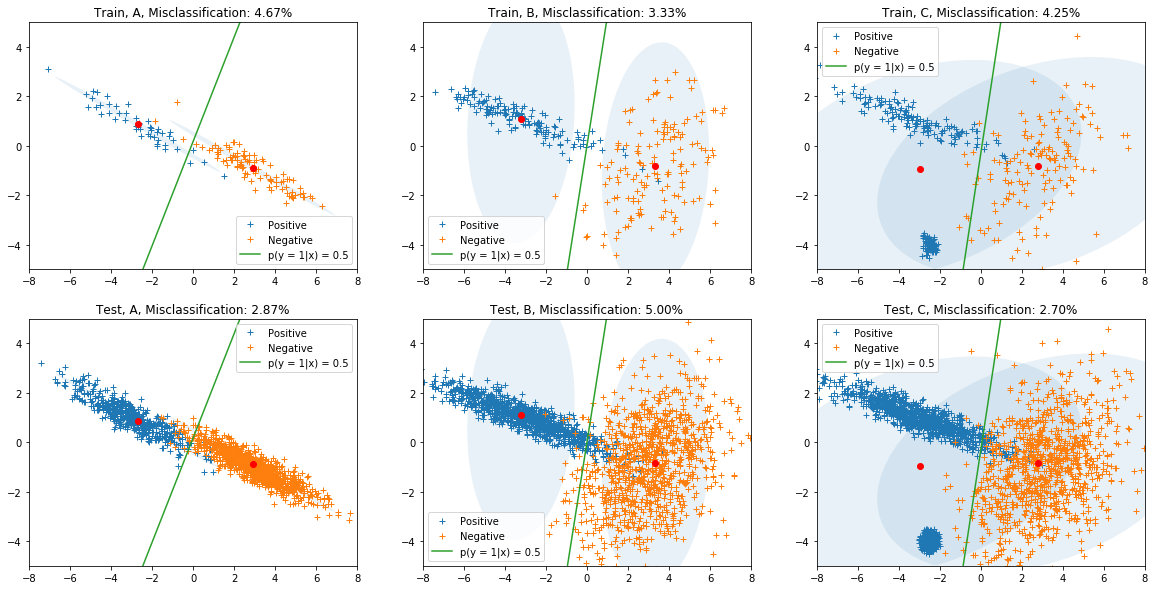

In [13]:
# Estimate pi, mu and sigma from MLE 
def lda_train(X, y):
    N = len(y)
    n = np.sum(y)
    pi = n/N
    mu1 = np.matrix( np.sum(X[y], axis=0)/n ).T 
    mu0 = np.matrix( np.sum(X[~y], axis=0)/(N - n) ).T 
    s = np.matrix("0. 0.; 0. 0.")
    for j in range(N):
        diff = np.matrix(X[j, :]-mu1.T*y[j]-mu0.T*(1-y[j]))
        s += diff.T * diff
    s /= N
    a = (mu1 - mu0).T*s
    b = mu1.T * s.I * mu1 * 0.5 + \
        - mu0.T * s.I * mu0 * 0.5 + \
        np.log(pi/(1-pi))
    return np.asarray(a)[0,:], np.sum(b), np.asarray(mu0), np.asarray(mu1), s
    
def lda_plot(ax, a, b, mu0, mu1, s):
    plt.plot(mu0[0], mu0[1], "ro")
    plt.plot(mu1[0], mu1[1], "ro")
    plot_ellipse(mu0, s, ax, alpha=0.1)
    plot_ellipse(mu1, s, ax, alpha=0.1)
    plt.legend()
    
LDA = Regressor(lda_train, affine_predict, affine_separate)
LDA.Train(data)
predictions = LDA.Fit(data)
LDA.PlotClassification(data, predictions, callback=lda_plot)

A few limitations clearly appear:
    
    1. The slope of the boundary line does not depend on the variance of the data, but only on the mean. Therefore, for badly conditioned problems, such as the dataset A, the boundary line is out of blue. An improvement would be to normalize the features.
    
    2. The hypothesis of a same variance is really strong and it does not hold on datasets B and C. As a consequence, the ellipse, representing the uncertainty does not fit with the data an the model has poor generalization properties. This explain why the misclassification rate is higher for the test dataset B (4.65%), than for the train dataset B (2.67%).

## Logistic Regression

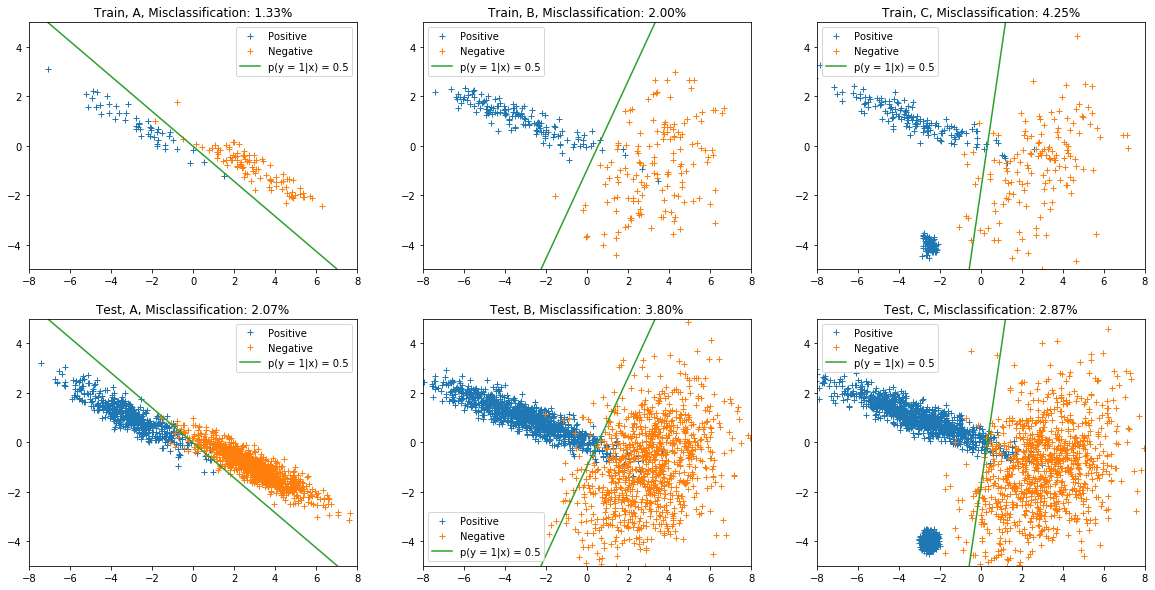

In [15]:
sigmoid = lambda z: 1/(1+np.exp(-z))

def logit_train(X, y, w0=None, b=1, niter=100):

    one = np.ones((X.shape[0], 1))
    X = np.asmatrix(np.concatenate((X,one), axis=1)).T

    if w0 is None:
        w0 = np.matrix("1 1 1").T
        w0 = w0/np.sum(w0.T * w0)
        
    w = w0
    for j in range(niter):
        eta = sigmoid(w.T*X)
        Deta = np.asmatrix(np.diag(np.asarray(np.multiply(eta,1-eta))[0,:]))
        hessian = (X*Deta*X.T)
        if np.linalg.det(hessian) < 1e-7:
            print("Hessian is not invertible")
            break
        w = w + (X*Deta*X.T).I*X*(y-eta).T
        w /= np.sum(w.T * w)
    
    return np.asarray(w[:-1]), np.sum(w[-1])


logit_regressor = Regressor(logit_train, affine_predict, affine_separate)
logit_regressor.Train(data, niter=200)
predictions = logit_regressor.Fit(data)
logit_regressor.PlotClassification(data, predictions)

## Linear Regression

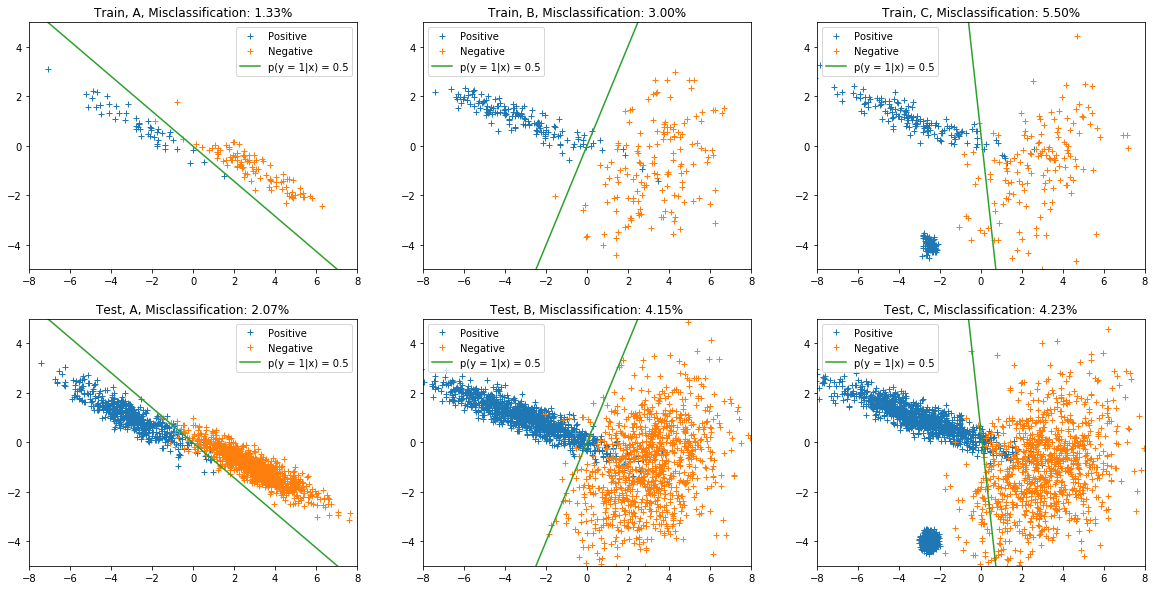

In [14]:
def linear_train(X, y):
    one = np.ones((X.shape[0], 1))
    X_ext = np.asmatrix(np.concatenate((X,one), axis=1))
    w_ext = (X_ext.T * X_ext).I * X_ext.T * np.asmatrix(2*y-1).T
    return np.asarray(w_ext[:-1]), np.sum(w_ext[-1])


linear_regressor = Regressor(linear_train, affine_predict, affine_separate)
linear_regressor.Train(data)
predictions = linear_regressor.Fit(data)
linear_regressor.PlotClassification(data, predictions)

## QDA

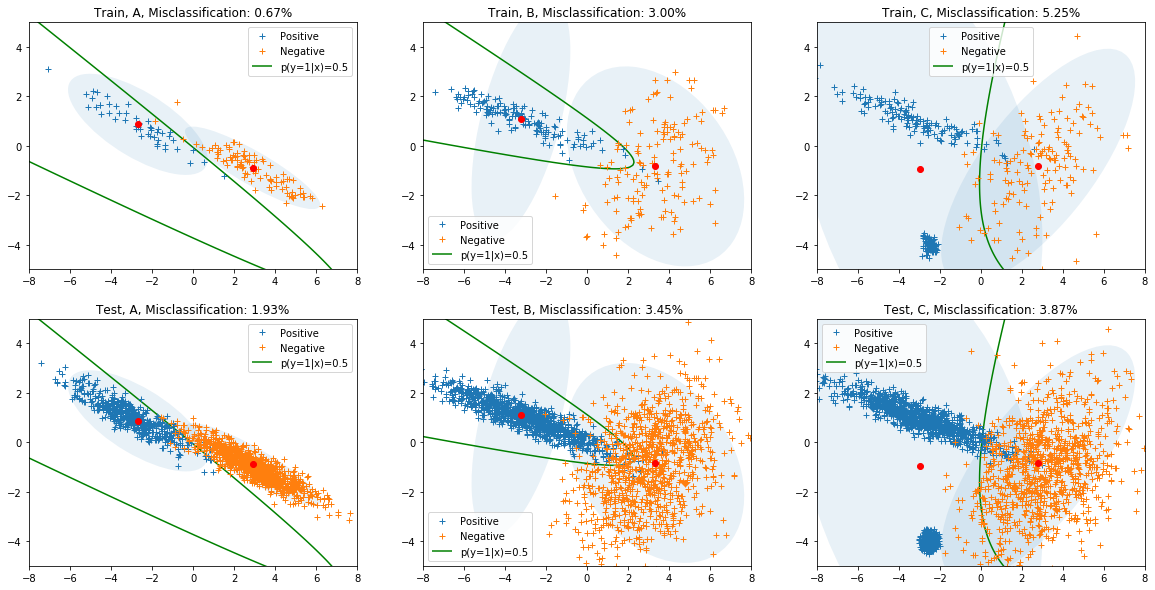

In [6]:
def qda_train(X, y):
    N = len(y)
    n = np.sum(y)
    pi = n/N
    mu1 = np.matrix( np.sum(X[y], axis=0)/n ).T 
    mu0 = np.matrix( np.sum(X[~y], axis=0)/(N - n) ).T 
    
    s1 = np.matrix("0. 0.; 0. 0.")
    s0 = np.matrix("0. 0.; 0. 0.")
    for j in range(N):
        diff = np.matrix((X[j, :]-mu1.T)*y[j])
        s1 += diff.T * diff
        
        diff = np.matrix((X[j, :]-mu0.T)*(1-y[j]))
        s0 += diff.T * diff
    s1 /= n   
    s0 /= N-n
    
    a = (s1.I-s0.I)/2
    b = mu0.T*s0.I - mu1.T*s1.I
    c = (np.log(np.linalg.det(s1)) - np.log(np.linalg.det(s0)))*0.5 \
        + np.log((1-pi)/pi) \
        + mu1.T*s1.I*mu1 - mu0.T*s0.I*mu0
    
    return a, b, c, np.asarray(mu0), np.asarray(mu1), s0, s1, pi


def qda_plot(ax, a, b, c, mu0, mu1, s0, s1, pi):
    plt.plot(mu0[0], mu0[1], "ro")
    plt.plot(mu1[0], mu1[1], "ro")

    plot_ellipse(mu0, s0, ax, alpha=0.1)
    plot_ellipse(mu1, s1, ax, alpha=0.1)
    plt.legend()


QDA = Regressor(qda_train, quadratic_predict, quadratic_separate)
params = QDA.Train(data)
predictions = QDA.Fit(data)

QDA.PlotClassification(data, predictions, callback=qda_plot)
